# Reinforcement Learning
# Cours 3 : Policy Iteration and Value Iteration

Pour trouver une politique optimale, il existe deux grandes familles d'algorithmes : la programmation dynamique (résoudre le problème en le décomposant récursivement en plus petits problèmes) et les simulations de Monte-Carlo (faire des expériences pour estimer les distributions de probabilités). 

Dans ce TP, nous étudions deux types d'algorithme utilisant la programmation dynamique : les itérations sur les valeurs et les itérations sur la politique.


RAPPEL : 1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait en groupe de 2 à 4. Aucun groupe de plus de 4 personnes. 

Vous allez rendre le TP dans une archive ZIP. L'archive ZIP contient ce notebook au format `ipynb`, mais aussi exporté en PDF & HTML. 
L'archive ZIP doit aussi contenir un fichier txt appelé `groupe.txt` sous le format:

```
Nom1, Prenom1, Email1, NumEtudiant1
Nom2, Prenom2, Email2, NumEtudiant2
Nom3, Prenom3, Email3, NumEtudiant3
Nom4, Prenom4, Email4, NumEtudiant4
```

Un script vient extraire vos réponses : ne changez pas l'ordre des cellules et soyez sûrs que les graphes sont bien présents dans la version notebook soumise. 

In [6]:
import matplotlib.pyplot as plt
import torch
import networkx as nx

### I. Estimation de la fonction de valeur d'un gridword

Nous avons vu en cours que :

$$v_\pi (s) = \mathbb{E}_\pi \left( G_t | s \right) = \sum_{s'} p(s'|s, a)\left[r+\gamma v_\pi(s') \right]$$

Dans le cas où les dynamiques de l'environnement sont entièrement connus, $p(s'|s, a)$ peut s'exprimer sous la forme d'un tensor et l'équation précédente aboutit à un système d'équations linéaires. Le problème est donc résolvable, mais la résolution risque d'être longue si l'environnement est grand. 

On cherche plutôt une résolution itérative qui applique le principe de la programmation dynamique. Concrètement, on part d'une fonction de valeur arbitraire $v_0$ (par exemple nulle partout), puis on y applique à chaque étape l'équation de Bellman :
$$v_{k+1} (s) = \sum_{s'} p(s'|s, a)\left[r+\gamma v_k(s') \right]$$
Lorsque l'algorithme a convergé vers un point fixe $v_\infty$, nous avons fini d'évaluer $v_\pi$, puisque ce dernier est l'unique point fixe de la fonction de valeur.

Cet algorithme est appelé l'**évaluation itérative de la politique**.

On considère par la suite le "gridworld" suivant :

![gridworld](https://github.com/Miolith/reinforcement-learning/blob/master/img/grid-world.png?raw=1)

Les cases grisées sont terminales et la récompense est de -1 sur toutes les transitions.
La taille du gridworld est une constante `CUBE_SIDE`.

**Q1: évaluez la fonction de valeur de la politique aléatoire à l'aide d'un algorithme itératif. Arrếtez l'algorithme lorsque les valeurs n'ont pas évolué de plus de 1e-2.**

In [7]:
from tabulate import tabulate
import typing as t
from dataclasses import dataclass, field
import random
import torch
from time import time

Action = t.Literal["L", "R", "U" , "D"]
CUBE_SIDE = 6

@dataclass
class State: 
    """
    It represents any cell in the world
    """
    cell: int
    value: int = 0
    
    def __post_init__(self):
        self.bounds = {
            'L': self.cell - self.cell % CUBE_SIDE,
            'R': self.cell - self.cell % CUBE_SIDE + (CUBE_SIDE - 1),
            'U': self.cell % CUBE_SIDE,
            'D': self.cell % CUBE_SIDE + CUBE_SIDE * (CUBE_SIDE - 1),
        }
        self.neighbors = [self.act(a) for a in "LRUD"]
        assert all(i >= 0 and i < CUBE_SIDE*CUBE_SIDE for i in self.neighbors)
    
    def is_termination(self):
        return self.cell in {0, CUBE_SIDE * CUBE_SIDE - 1}

    def act(self, a: Action):
        """
        Get next state
        """
        if a == 'L': 
            return min(self.bounds['R'], max(self.bounds['L'], self.cell - 1))
        if a == 'R': 
            return min(self.bounds['R'], max(self.bounds['L'], self.cell + 1))
        if a == 'U': 
            return min(self.bounds['D'], max(self.bounds['U'], self.cell - 4))
        if a == 'D':
            return min(self.bounds['D'], max(self.bounds['U'], self.cell + 4))
        raise ValueError('Unexpected action')
    

def init_states():
    return [State(i) for i in range(CUBE_SIDE * CUBE_SIDE)]


@dataclass
class Env:
    states: t.List[State] = field(default_factory=init_states)

def random_policy_value(env: Env, gamma: float = 0.9, epsilon: float = 1e-2):
    """
        Compute the values of the random policy
    """
    states = env.states
    num_iterations = 0
    while True:
        num_iterations += 1
        delta = 0
        for s in states:
            if s.is_termination():
                continue
            v = s.value
            s.value = sum([
                    0.25 * (-1 + gamma * states[s.act(a)].value)
                for a in "LRUD"])
            delta = max(delta, abs(v - s.value))
        if delta < epsilon:
            break
    return num_iterations, env

env = Env()
num_iterations, env = random_policy_value(env)

[(s.cell, s.value) for s in env.states]

[(0, 0),
 (1, -6.644668970140989),
 (2, -8.68225421516144),
 (3, -9.413514717900709),
 (4, -9.69125498430674),
 (5, -9.782938219363281),
 (6, -9.427027105147564),
 (7, -9.630849500978723),
 (8, -9.7646744814652),
 (9, -9.802493129133484),
 (10, -9.735782202695594),
 (11, -9.768537554673816),
 (12, -9.844025399963348),
 (13, -9.852570127811475),
 (14, -9.841079067567392),
 (15, -9.849345780530232),
 (16, -9.865711368173262),
 (17, -9.869882137893072),
 (18, -9.86875884453481),
 (19, -9.867403191623888),
 (20, -9.851942456141636),
 (21, -9.845424211062365),
 (22, -9.857624385532201),
 (23, -9.852112821192398),
 (24, -9.774854160107823),
 (25, -9.744663931849026),
 (26, -9.812051103588985),
 (27, -9.776468702472812),
 (28, -9.643972658952798),
 (29, -9.44308988082211),
 (30, -9.797018419317242),
 (31, -9.708595922048733),
 (32, -9.43263453670931),
 (33, -8.70188513322465),
 (34, -6.660086319100251),
 (35, 0)]

La politique gloutonne cherche uniquement à exploiter, sans aucune exploration. A chaque instant, elle choisit l'action qui permet de maximiser la fonction de valeur :

$$\pi(s) = \text{argmax}_a \sum_{s'} p(s'|s,a)[r+\gamma V(s')]$$

**Q2: calculez la politique ainsi obtenue. Vérifiez qu'il s'agit de la politique optimale. Combien d'itérations ont été nécessaires pour obtenir ce résultat ?**

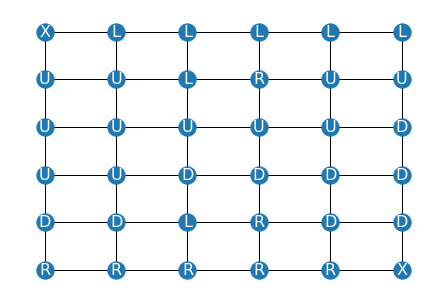

nombre d'itérations : 31


In [8]:
def get_policy(env: Env, gamma: float = 0.9):
    """
    Compute the optimal policy
    """
    states = env.states
    policy = {}
    for s in states:
        if s.is_termination():
            continue
        policy[s.cell] = max([
            (a, 0.25 * (-1 + gamma * states[s.act(a)].value))
            for a in "LRUD"
        ], key=lambda x: x[1])[0]
    return policy

def plot_policy(policy):
    """
    Display the policy
    """
    policy[0] = 'X'
    policy[CUBE_SIDE * CUBE_SIDE - 1] = 'X'
    G = nx.grid_2d_graph(CUBE_SIDE, CUBE_SIDE)
    pos = {n: n for n in G.nodes()}
    labels = {n: policy[(CUBE_SIDE - n[1] - 1) * CUBE_SIDE + n[0]] for n in G.nodes()}
    nx.draw(G, pos, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color="w")
    plt.show()

p = get_policy(env)
plot_policy(p)

print("nombre d'itérations :", num_iterations)

La politique est souvent mais pas toujours optimale.

### II. Algorithme *policy iteration*

Une amélioration de l'algorithme consiste 1) à évaluer la fonction de valeur sur un petit nombre d'itérations (on testera en Q3 avec une seule itération), puis 2) à mettre à jour la politique, puis à recommencer l'étape 1). On peut arrếter l'entraînement lorsque la politique a convergé.

**Q3: implémentez cet algorithme. Est-il plus rapide ?**

policy_iteration prend 3.08 ms


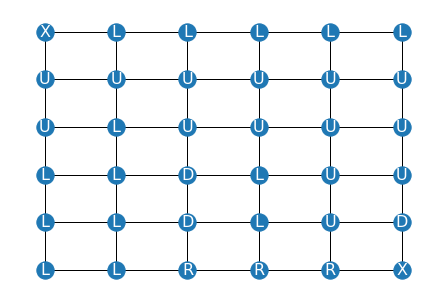

random_policy_value prend 6.26 ms


In [9]:
def policy_iteration(env: Env, n: int, gamma: float = 0.9, epsilon: float = 1e-2):
    """
      Value iteration algorithm with n iteration
    """
    states = env.states
    p = {}
    while True:
        for i in range(n):
            for s in states:
                if s.is_termination():
                    continue
                v = s.value
                s.value = sum([
                        0.25 * (-1 + gamma * states[s.act(a)].value)
                    for a in "LRUD"])
        p_k = p
        p = get_policy(env, gamma)
        if p_k == p:
            break
        
    return p

env = Env()

start = time()
p = policy_iteration(env, n=1)
end = time()

print("policy_iteration prend %.2f ms" % ((end - start) * 1000))
plot_policy(p)
env = Env()

start = time()
V = random_policy_value(env)
get_policy(env)
end = time()

print("random_policy_value prend %.2f ms" % ((end - start) * 1000))

*Policy Iteration* est plus rapide que l'implémentation précédente mais moins optimale.

### III. Algorithme *value iteration*

Une autre variante conserve la politique optimale tout en long de l'entraînement, mais met à jour la fonction de valeur avec l'équation suivante :

$$v_{k+1} (s) = \max_{a} \sum_{s'} p(s'|s, a)\left[r+\gamma v_k(s') \right]$$

Une fois que la fonction de valeur a convergé, on calcule la politique avec :

$$\pi(s) = argmax_a \sum_{s'} p(s'|s,a)[r+\gamma V(s')]$$


**Q4: implémentez cet algorithme.**

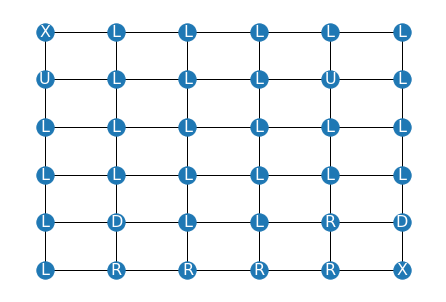

value_iteration prend 0.86 ms


In [10]:
def value_iteration(env: Env, gamma: float = 0.9, epsilon: float = 1e-2):
    """
        Value iteration algorithm
    """
    states = env.states
    while True:
        delta = 0
        for s in states:
            if s.is_termination():
                continue
            v = s.value
            s.value = max([
                    0.25 * (-1 + gamma * states[s.act(a)].value)
                for a in "LRUD"])
            delta = max(delta, abs(v - s.value))
        if delta < epsilon:
            break
    return env

env = Env()

start = time()
V = value_iteration(env)
p = get_policy(env)
end = time()

plot_policy(p)

print("value_iteration prend %.2f ms" % ((end - start) * 1000))

*[Ajoutez votre commentaire ici]*

**Q5: Quel algorithme vous paraît le plus judicieux ?**

La première version de l'algorithme paraît être le plus judicieux car il permet d'obtenir la politique la plus optimale.